# Fraud Detection Project

In [ ]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# for showing all the columns

pd.options.display.max_columns = 31


In [2]:
# uploading the data set - later integrate the Kaggle API and use data directly from Kaggle

df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# checking for NA values
df.isnull().sum().max()

0

Text(0.5, 1.0, 'Class Distrbutions')

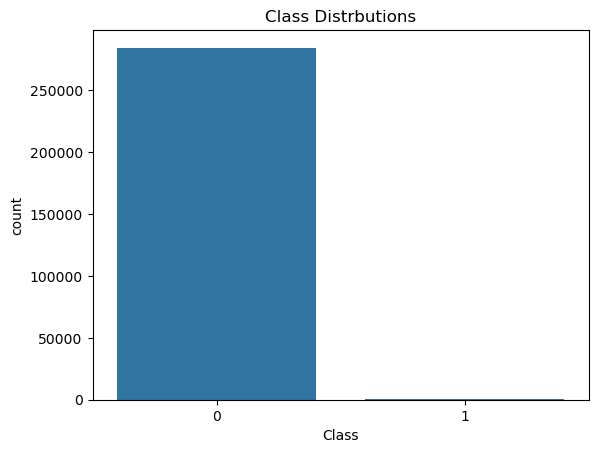

In [5]:
# checking the distribution of the outcome class

sns.countplot(df, x = 'Class')
plt.title('Class Distrbutions')

# Judging by the plot we need to account for this class imabalance in out model selection & data preprcoessing.

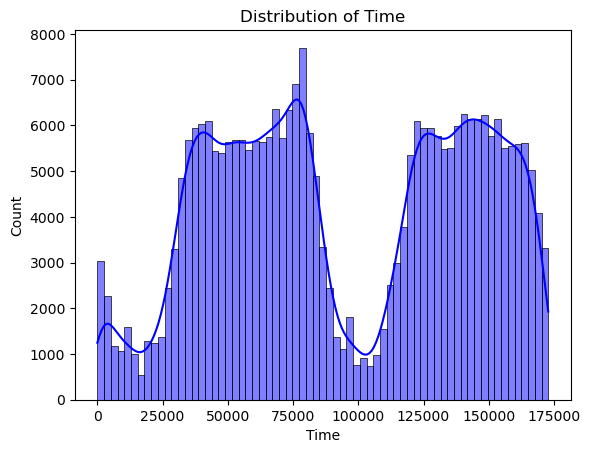

In [6]:
# plotting the distribution of time and amount columnns

sns.histplot(data = df, x ='Time', kde= True, color = 'blue')
plt.title('Distribution of Time')
plt.show()

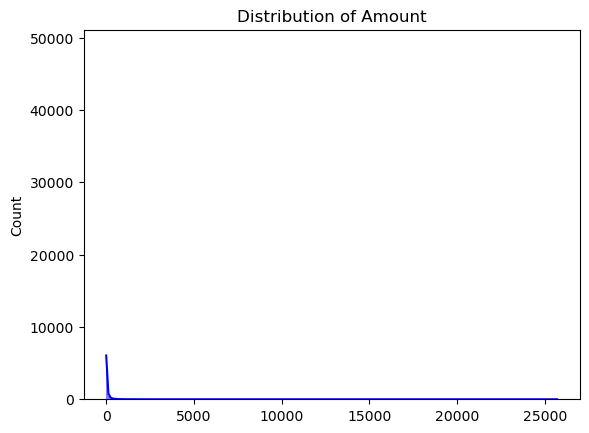

In [7]:
amount = df['Amount'].values
sns.histplot(amount, kde= True, color = 'blue')
plt.title('Distribution of Amount')

plt.show()

In [8]:
# sacling the time and amount columns

# RobustScaler will be used

from sklearn.preprocessing import RobustScaler

scaler_rob = RobustScaler()

df['Time_scaled'] = scaler_rob.fit_transform(df['Time'].values.reshape(-1,1))
df['Amount_scaled'] = scaler_rob.fit_transform(df['Amount'].values.reshape(-1,1))

df.drop(['Time','Amount'],axis =1, inplace = True)

In [9]:
# adjusting the column order for better visibility
cols_to_move = df.columns[-2:].tolist()
remaining_cols = df.columns[:-2].tolist()
new_col_order =  cols_to_move + remaining_cols
df = df[new_col_order]
df.head()

,Time_scaled,Amount_scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.994983,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.994983,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-0.994972,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.994972,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.994960,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [10]:
# splitting the data

from sklearn.model_selection import train_test_split
# checking the class imbalance in the data
print('No Frauds', round(df['Class'].value_counts()[0]/len(df)*100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df)*100,2), '% of the dataset')

X = df.drop('Class', axis =1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X,y, test_size = 0.2, random_state =42)

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


train_unique_label, train_counts_label =np.unique(original_ytrain, return_counts = True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts = True)

print(train_counts_label/len(original_ytrain))
print(test_counts_label/len(original_ytest))


No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
[0.99827075 0.00172925]
[0.99827955 0.00172045]


## Random Undersampling


In [11]:
df = df.sample(frac =1)
fraud_df = df.loc[df['Class']==1]
non_fraud_df = df.loc[df['Class']==0][:492]

temp_df = pd.concat([fraud_df,non_fraud_df])
new_df = temp_df.sample(frac =1, random_state=42)

new_df.head()

,Time_scaled,Amount_scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
247829,0.810771,0.561727,1.963609,-0.183782,-1.926045,0.193976,0.207336,-1.464289,0.620655,-0.396474,-0.096047,0.385509,0.976478,0.320686,-1.200576,1.152585,-0.305407,-0.116102,-0.444297,-0.105708,0.243212,-0.164751,0.154278,0.332447,0.002840,0.120206,0.112474,0.701271,-0.145860,-0.083631,0
151807,0.136268,0.161951,-3.552173,5.426461,-3.731810,6.679062,-2.187543,2.433940,-8.748110,-12.108284,-2.856359,-5.665862,2.540836,-6.147054,1.796891,-4.328989,-0.150037,-1.839005,-3.354638,-0.282307,0.148592,3.792667,-5.688990,2.510980,0.953933,-0.542506,-0.620152,0.406013,0.023025,0.164741,1
187115,0.501627,-0.112485,1.990016,-0.603964,-0.087481,0.233323,-0.659067,0.484143,-1.143251,0.238764,1.806177,-0.193898,-1.588667,0.181967,0.387289,-0.470062,1.138078,0.793834,-1.028520,0.825916,-0.205419,-0.141324,0.195797,0.743121,0.144249,0.094404,-0.250292,-0.263229,0.066708,-0.021448,0
17317,-0.658690,1.089779,-27.848181,15.598193,-28.923756,6.418442,-20.346228,-4.828202,-19.210896,18.329406,-3.668735,-8.009159,4.303096,-6.008660,1.138969,-5.580447,-0.110737,-5.491073,-11.588544,-4.715420,0.734573,1.697856,1.802149,-2.062934,-1.269843,0.165409,1.999499,-0.211059,1.324809,0.388090,1
181966,0.475898,0.251520,-0.769172,1.342212,-2.171454,-0.151513,-0.648374,-0.973504,-1.706658,0.313745,-1.982302,-3.158127,1.341572,-3.299472,1.247647,-6.393373,-0.053205,-3.258046,-3.348896,0.217331,-0.917408,-0.102294,-0.036122,-0.753591,-0.047113,0.358493,-0.287407,0.476506,0.250531,0.250987,1


### Exploratory data analysis


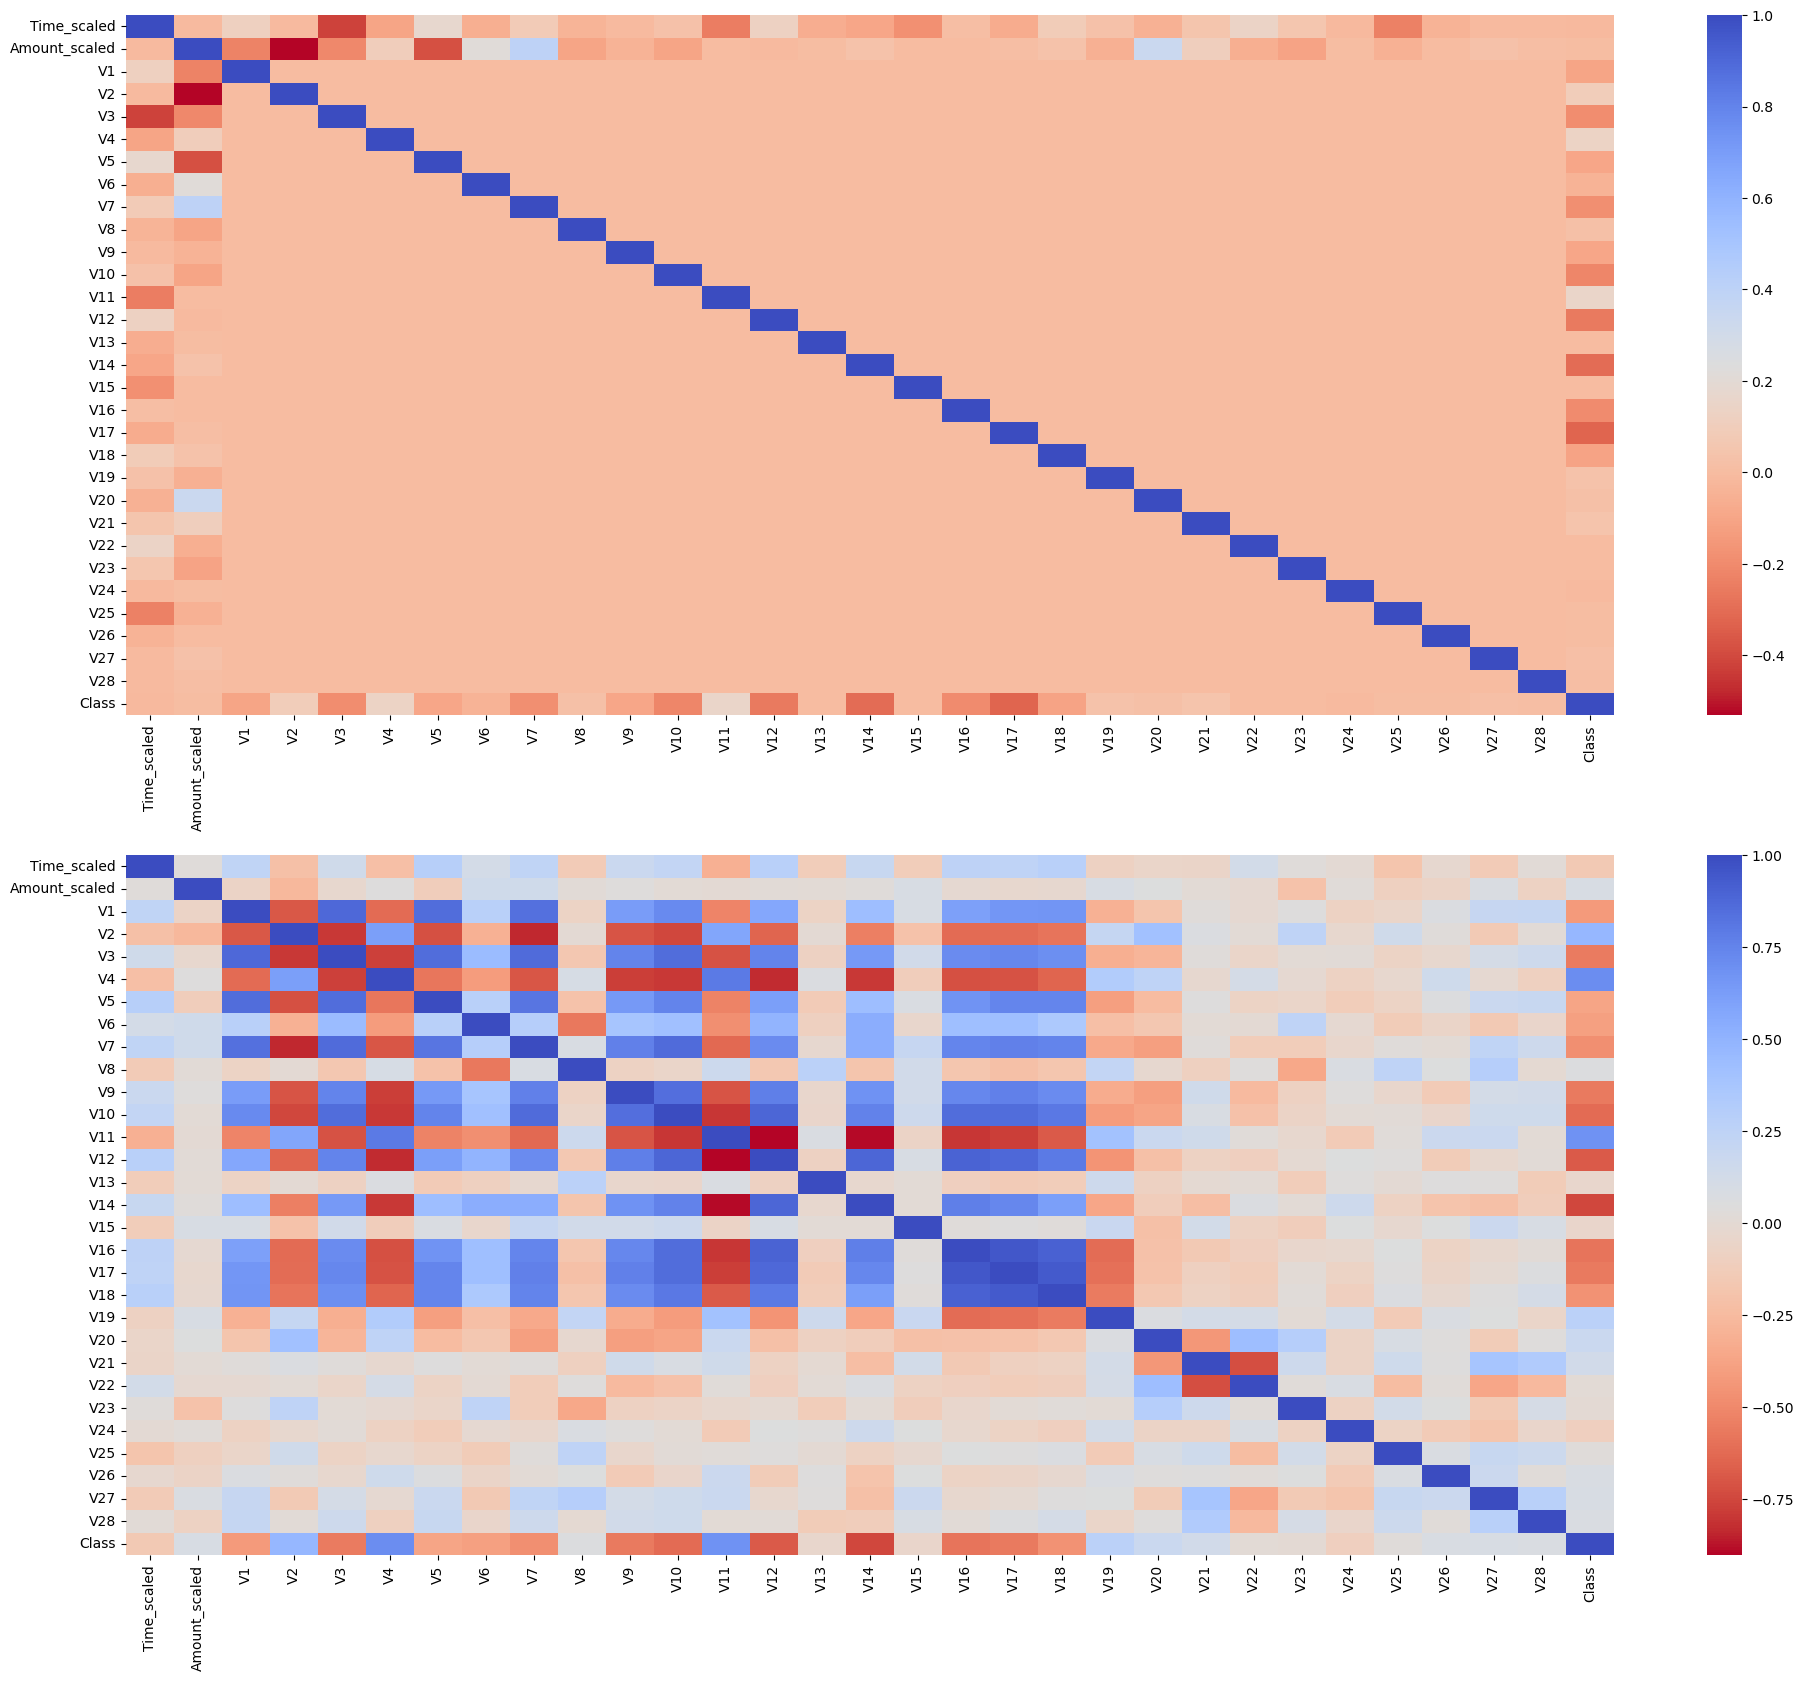

In [12]:
# developing a correlation matrix

f, (ax1,ax2) = plt.subplots(2,1, figsize = (24,20))

corr = df.corr()
sns.heatmap(corr, cmap ='coolwarm_r',ax =ax1)

corr_2 = new_df.corr()
sns.heatmap(corr_2, cmap ='coolwarm_r', ax = ax2)

plt.show()

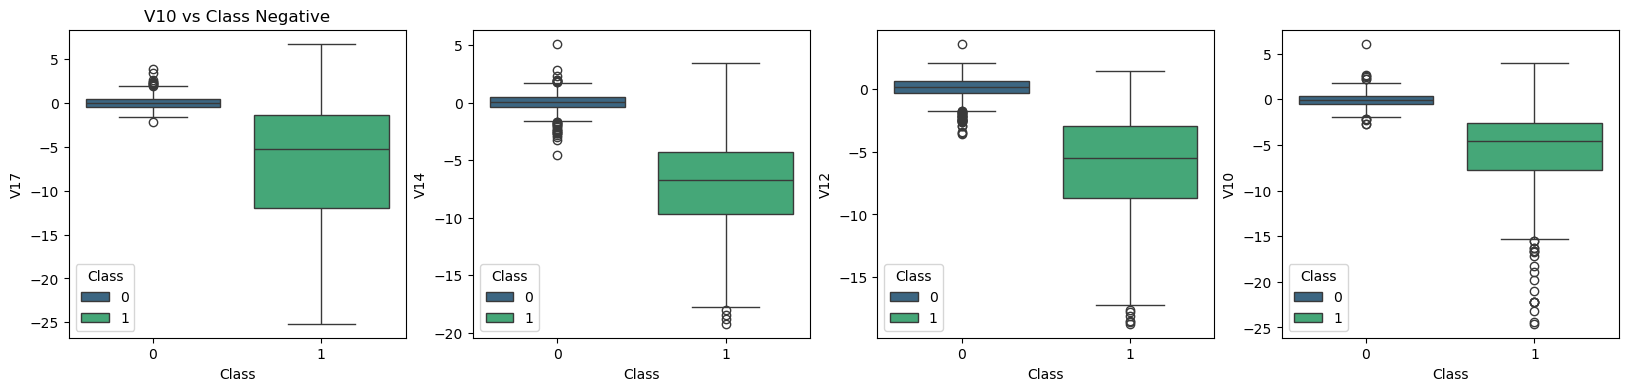

In [13]:
# checking the correlation of the features with the class
# Negative correlation
f,axes =plt.subplots(ncols=4,figsize = (20,4))

sns.boxplot(x='Class',y ='V17',hue='Class',data = new_df ,palette="viridis",ax=axes[0])
axes[0].set_title('V17 vs Class Negative')
sns.boxplot(x='Class',y ='V14',hue='Class',data = new_df ,palette="viridis",ax=axes[1])
axes[0].set_title('V14 vs Class Negative')
sns.boxplot(x='Class',y ='V12',hue='Class',data = new_df ,palette="viridis",ax=axes[2])
axes[0].set_title('V12 vs Class Negative')
sns.boxplot(x='Class',y ='V10',hue='Class',data = new_df ,palette="viridis",ax=axes[3])
axes[0].set_title('V10 vs Class Negative')
plt.show()

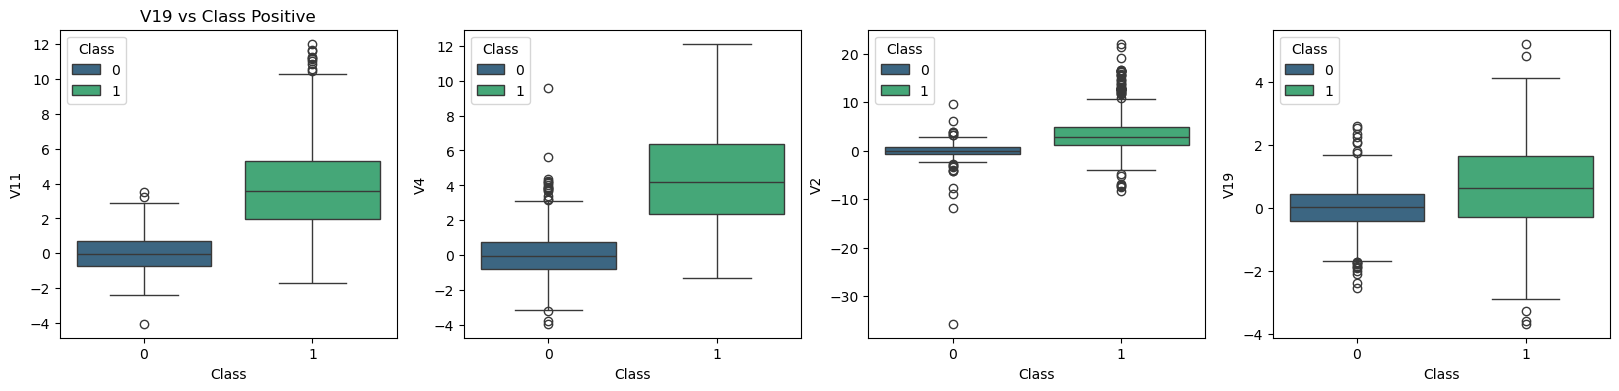

In [14]:
#positive correlation
f,axes =plt.subplots(ncols=4,figsize = (20,4))

sns.boxplot(x='Class',y ='V11',hue='Class',data = new_df ,palette="viridis",ax=axes[0])
axes[0].set_title('V11 vs Class Positive')
sns.boxplot(x='Class',y ='V4',hue='Class',data = new_df ,palette="viridis",ax=axes[1])
axes[0].set_title('V4 vs Class Positive')
sns.boxplot(x='Class',y ='V2',hue='Class',data = new_df ,palette="viridis",ax=axes[2])
axes[0].set_title('V2 vs Class Positive')
sns.boxplot(x='Class',y ='V19',hue='Class',data = new_df ,palette="viridis",ax=axes[3])
axes[0].set_title('V19 vs Class Positive')
plt.show()

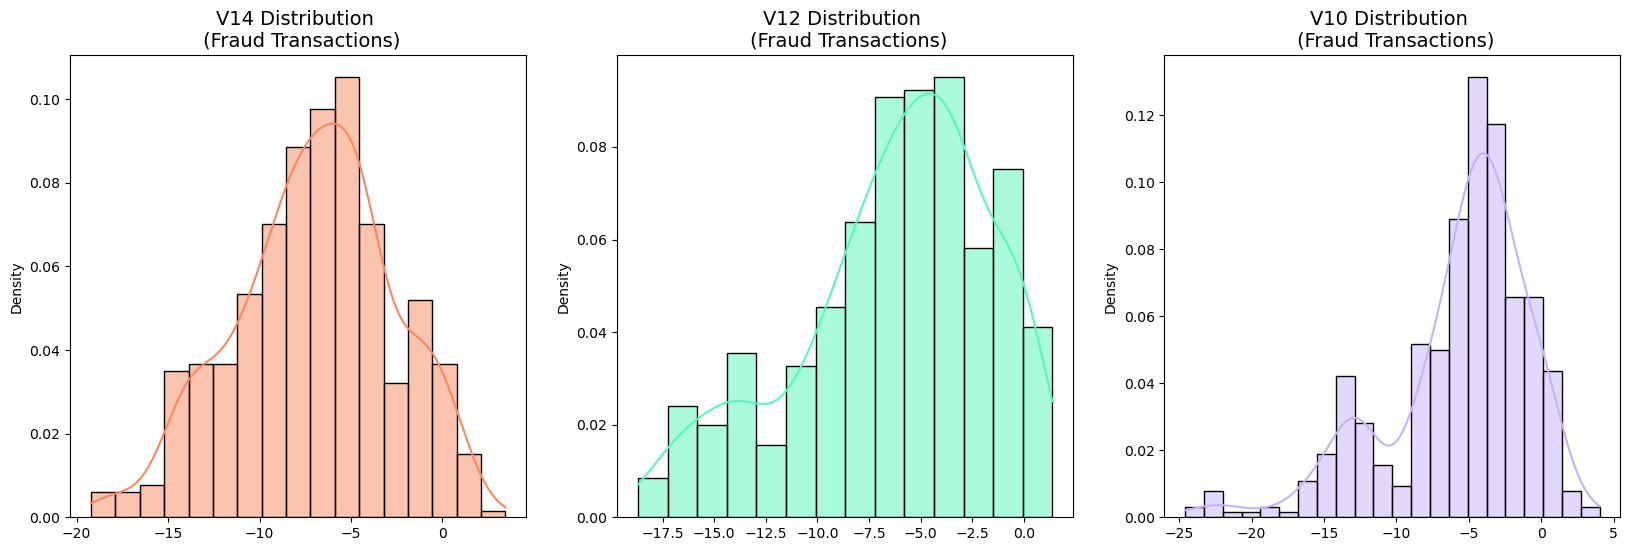

In [15]:
from scipy.stats import norm


# Set up the figure with 3 subplots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Feature V14 Fraud Distribution
v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.histplot(v14_fraud_dist, ax=ax1, kde=True, stat="density", color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

# Feature V12 Fraud Distribution
v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.histplot(v12_fraud_dist, ax=ax2, kde=True, stat="density", color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

# Feature V10 Fraud Distribution
v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.histplot(v10_fraud_dist, ax=ax3, kde=True, stat="density", color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

# Show the plot
plt.show()


In [16]:
# removing the extreme outliers - function we are Using IQR Method

def removing_outliers(df, feature_list):

    outlier_indexes =[]

    for _ in feature_list:

        q25,q75 =np.percentile(df[_].loc[df['Class']==1],25), np.percentile(df[_].loc[df['Class']==1],75)
        iqr = q75-q25

        cutoff = iqr*1.5
        lower, upper = q25-cutoff,q75+cutoff

        outliers = df[(df[_]<lower) | (df[_]>upper)].index
        outlier_indexes.extend(outliers)

        print(f"Feature {_}: Removed{ len(outliers)} Outliers")

    df_cleaned =df.drop(index = outlier_indexes)

    return df_cleaned



In [17]:
# function for plotting boxplot to check once again

def box_plot(df, feature_list):
    f,axes =plt.subplots(ncols=len(feature_list),figsize = (20,4))

    for index, i in enumerate(feature_list):
        sns.boxplot(x='Class',y =i,hue='Class',data = new_df ,palette="viridis",ax=axes[index])
        axes[index].set_title(f'{i} vs Class Positive')

    plt.show()




In [18]:
# Features to remove outliers from
features_to_clean = ['V14', 'V12', 'V10']

# Apply function
new_df = removing_outliers(new_df, features_to_clean)

Feature V14: Removed5 Outliers
Feature V12: Removed6 Outliers
Feature V10: Removed20 Outliers


In [19]:
my_list = ['V14', 'V12', 'V10']

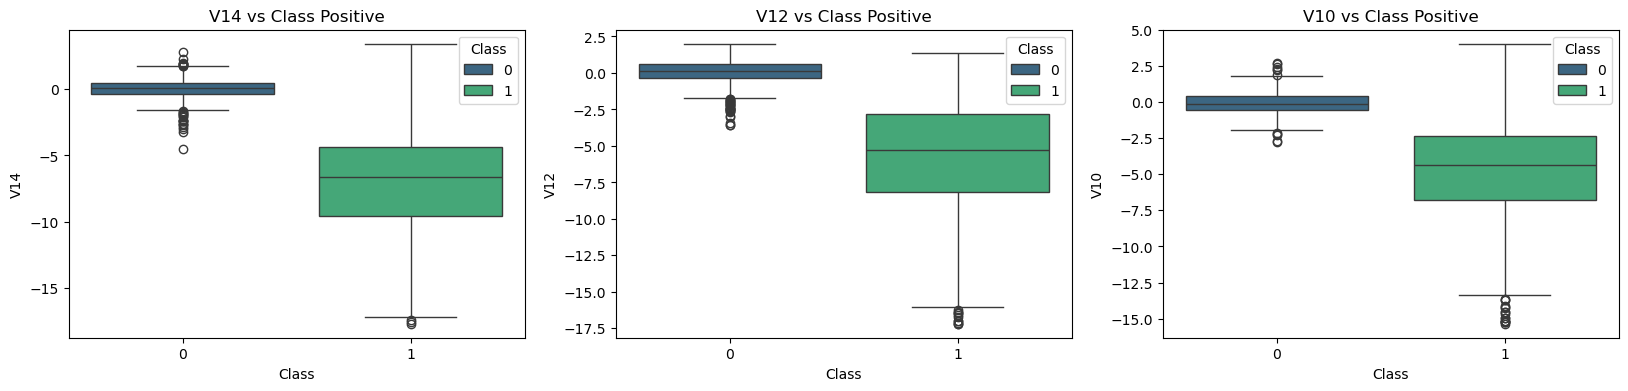

In [20]:
box_plot(new_df, my_list)

## Training a classifier


In [21]:
# test train split for the new df

X= new_df.drop('Class', axis =1)
y = new_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =42)

In [22]:
# creating a function that will run the given model and provide the results and metrics - for checking varioys models

def model_training(df, classifiers_dict):
    for model_name, clf in classifiers_dict.items():
        print(f"Training {model_name} Model")

        # splitting the daata first
        X = df.drop('Class', axis =1)
        y = df['Class']

        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =42)

        clf.fit(X_train,y_train)

        #predictions
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]

        # Evaluate model
        print(f"Classification Report for {model_name}\n")
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()
       
        # Plotting the AUC-ROC Curve
        fpr,tpr,threshold = roc_curve(y_test,y_pred_proba)
        roc_auc  = auc(fpr,tpr)


        # Plot AUC-ROC Curve
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # Random classifier line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.show()

In [25]:

# Define models in a dictionary
classifiers_v1 = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, scale_pos_weight=len(new_df[new_df['Class'] == 0]) / len(new_df[new_df['Class'] == 1]), random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100, random_state=42)
}

Training Logistic Regression Model
Classification Report for Logistic Regression

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       101
           1       0.98      0.91      0.94        90

    accuracy                           0.95       191
   macro avg       0.95      0.95      0.95       191
weighted avg       0.95      0.95      0.95       191



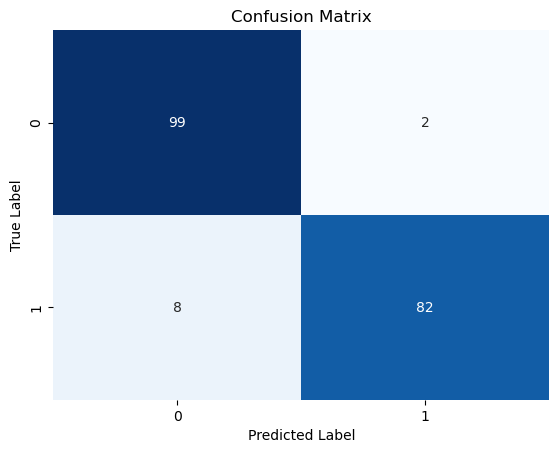

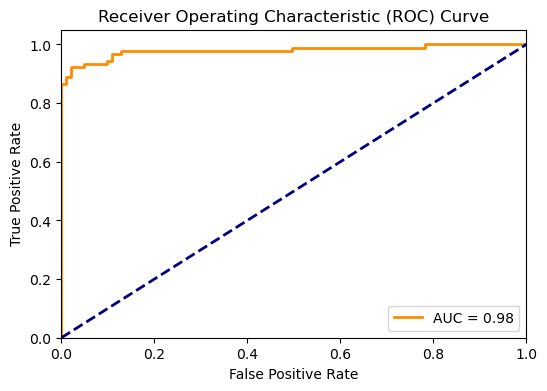

Training Random Forest Model
Classification Report for Random Forest

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       101
           1       0.96      0.89      0.92        90

    accuracy                           0.93       191
   macro avg       0.94      0.93      0.93       191
weighted avg       0.93      0.93      0.93       191



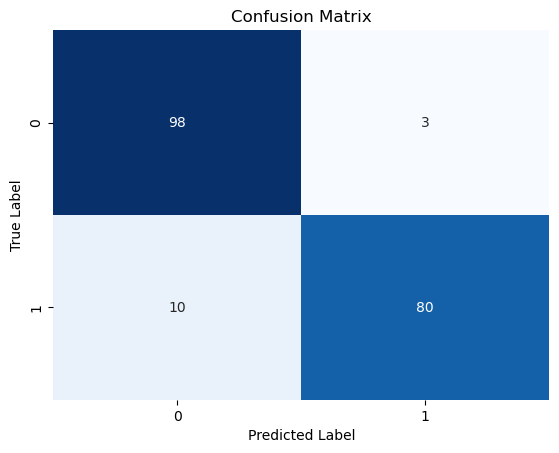

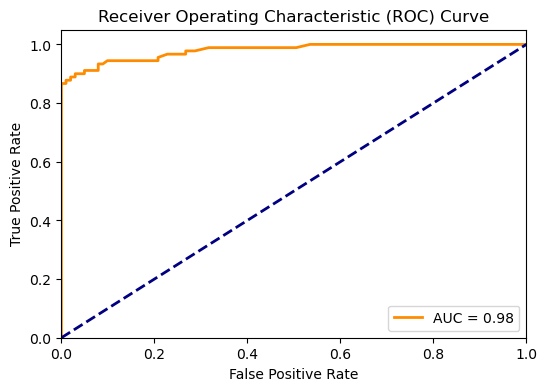

Training XGBoost Model
Classification Report for XGBoost

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       101
           1       0.98      0.88      0.92        90

    accuracy                           0.93       191
   macro avg       0.94      0.93      0.93       191
weighted avg       0.94      0.93      0.93       191



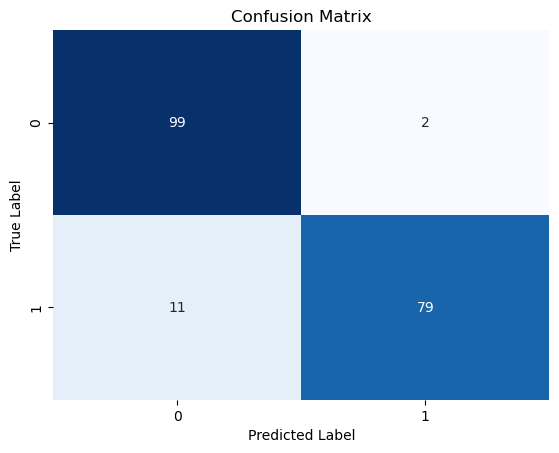

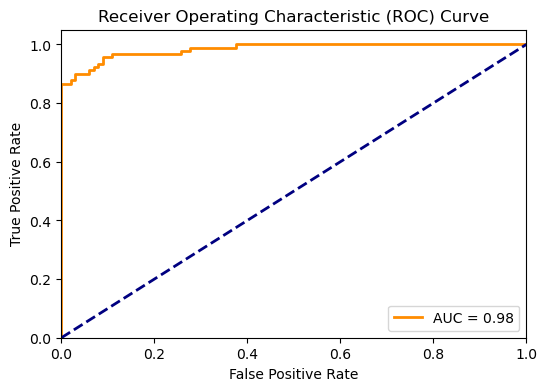

Training LightGBM Model
[LightGBM] [Info] Number of positive: 375, number of negative: 389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7629
[LightGBM] [Info] Number of data points in the train set: 764, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490838 -> initscore=-0.036653
[LightGBM] [Info] Start training from score -0.036653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

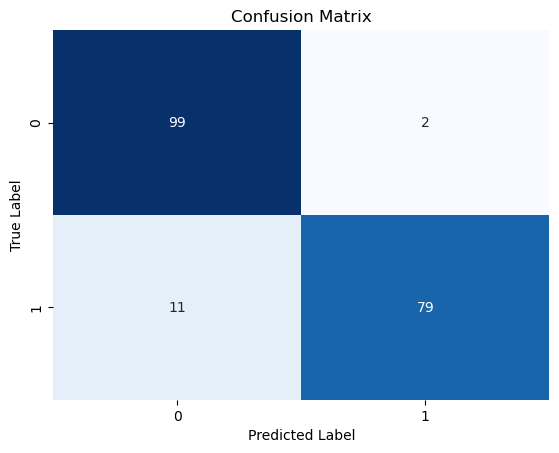

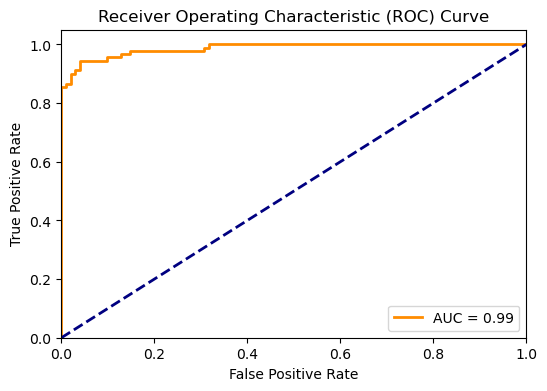

In [28]:
model_training(new_df, classifiers_v1)